
# How to Train YOLOv8 early fire Detection on a Custom Dataset



## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- CLI Basics
- Inference with Pre-trained COCO Model
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [25]:
!nvidia-smi

Thu Feb  2 13:52:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    30W /  70W |   1180MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
#import os
#HOME = os.getcwd()
HOME = "/content/drive/MyDrive/FireDetection"
print(HOME)

/content/drive/MyDrive/FireDetection


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **27.01.2023** with version **YOLOv8.0.20**.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [43]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.7/78.2 GB disk)


In [ ]:
# Git clone method (for development)

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -qe ultralytics

# from IPython import display
# display.clear_output()

# import ultralytics
# ultralytics.checks()

In [44]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics 

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://v8docs.ultralytics.com/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
100% 104k/104k [00:00<00:00, 7.55MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 14.3ms
Speed: 0.5ms pre-process, 14.3ms inference, 19.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

In [46]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)

  0%|          | 0.00/6.23M [00:00<?, ?B/s]


Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg


In [47]:
results[0].boxes.xyxy

tensor([[   0.,  314.,  625., 1278.],
        [  55.,  250.,  648., 1266.],
        [ 633.,  720.,  701.,  786.]], device='cuda:0')

In [48]:
results[0].boxes.conf

tensor([0.72712, 0.29066, 0.28456], device='cuda:0')

In [49]:
results[0].boxes.cls

tensor([ 0., 16.,  2.], device='cuda:0')

## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 110,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://ik.imagekit.io/roboflow/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)



## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together. 

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>




In [50]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet


from roboflow import Roboflow
rf = Roboflow(api_key="xxxxxxxxxxxxxxx")
project = rf.workspace("custom-thxhn").project("fire-wrpgm")
dataset = project.version(8).download("yolov8")


/content/drive/MyDrive/FireDetection/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to fire-8 in yolov8:: 100%|██████████| 1970/1970 [00:15<00:00, 123.45it/s]


## Custom Training

In [51]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

/content/drive/MyDrive/FireDetection
100% 21.5M/21.5M [00:01<00:00, 14.4MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/drive/MyDrive/FireDetection/datasets/fire-8/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

In [52]:
!ls {HOME}/runs/detect/train/

args.yaml					     train_batch1.jpg
confusion_matrix.png				     train_batch2.jpg
events.out.tfevents.1675348815.43529bab29be.37247.0  train_batch825.jpg
F1_curve.png					     train_batch826.jpg
P_curve.png					     train_batch827.jpg
PR_curve.png					     val_batch0_labels.jpg
R_curve.png					     val_batch0_pred.jpg
results.csv					     val_batch1_labels.jpg
results.png					     val_batch1_pred.jpg
train_batch0.jpg				     weights


/content/drive/MyDrive/FireDetection


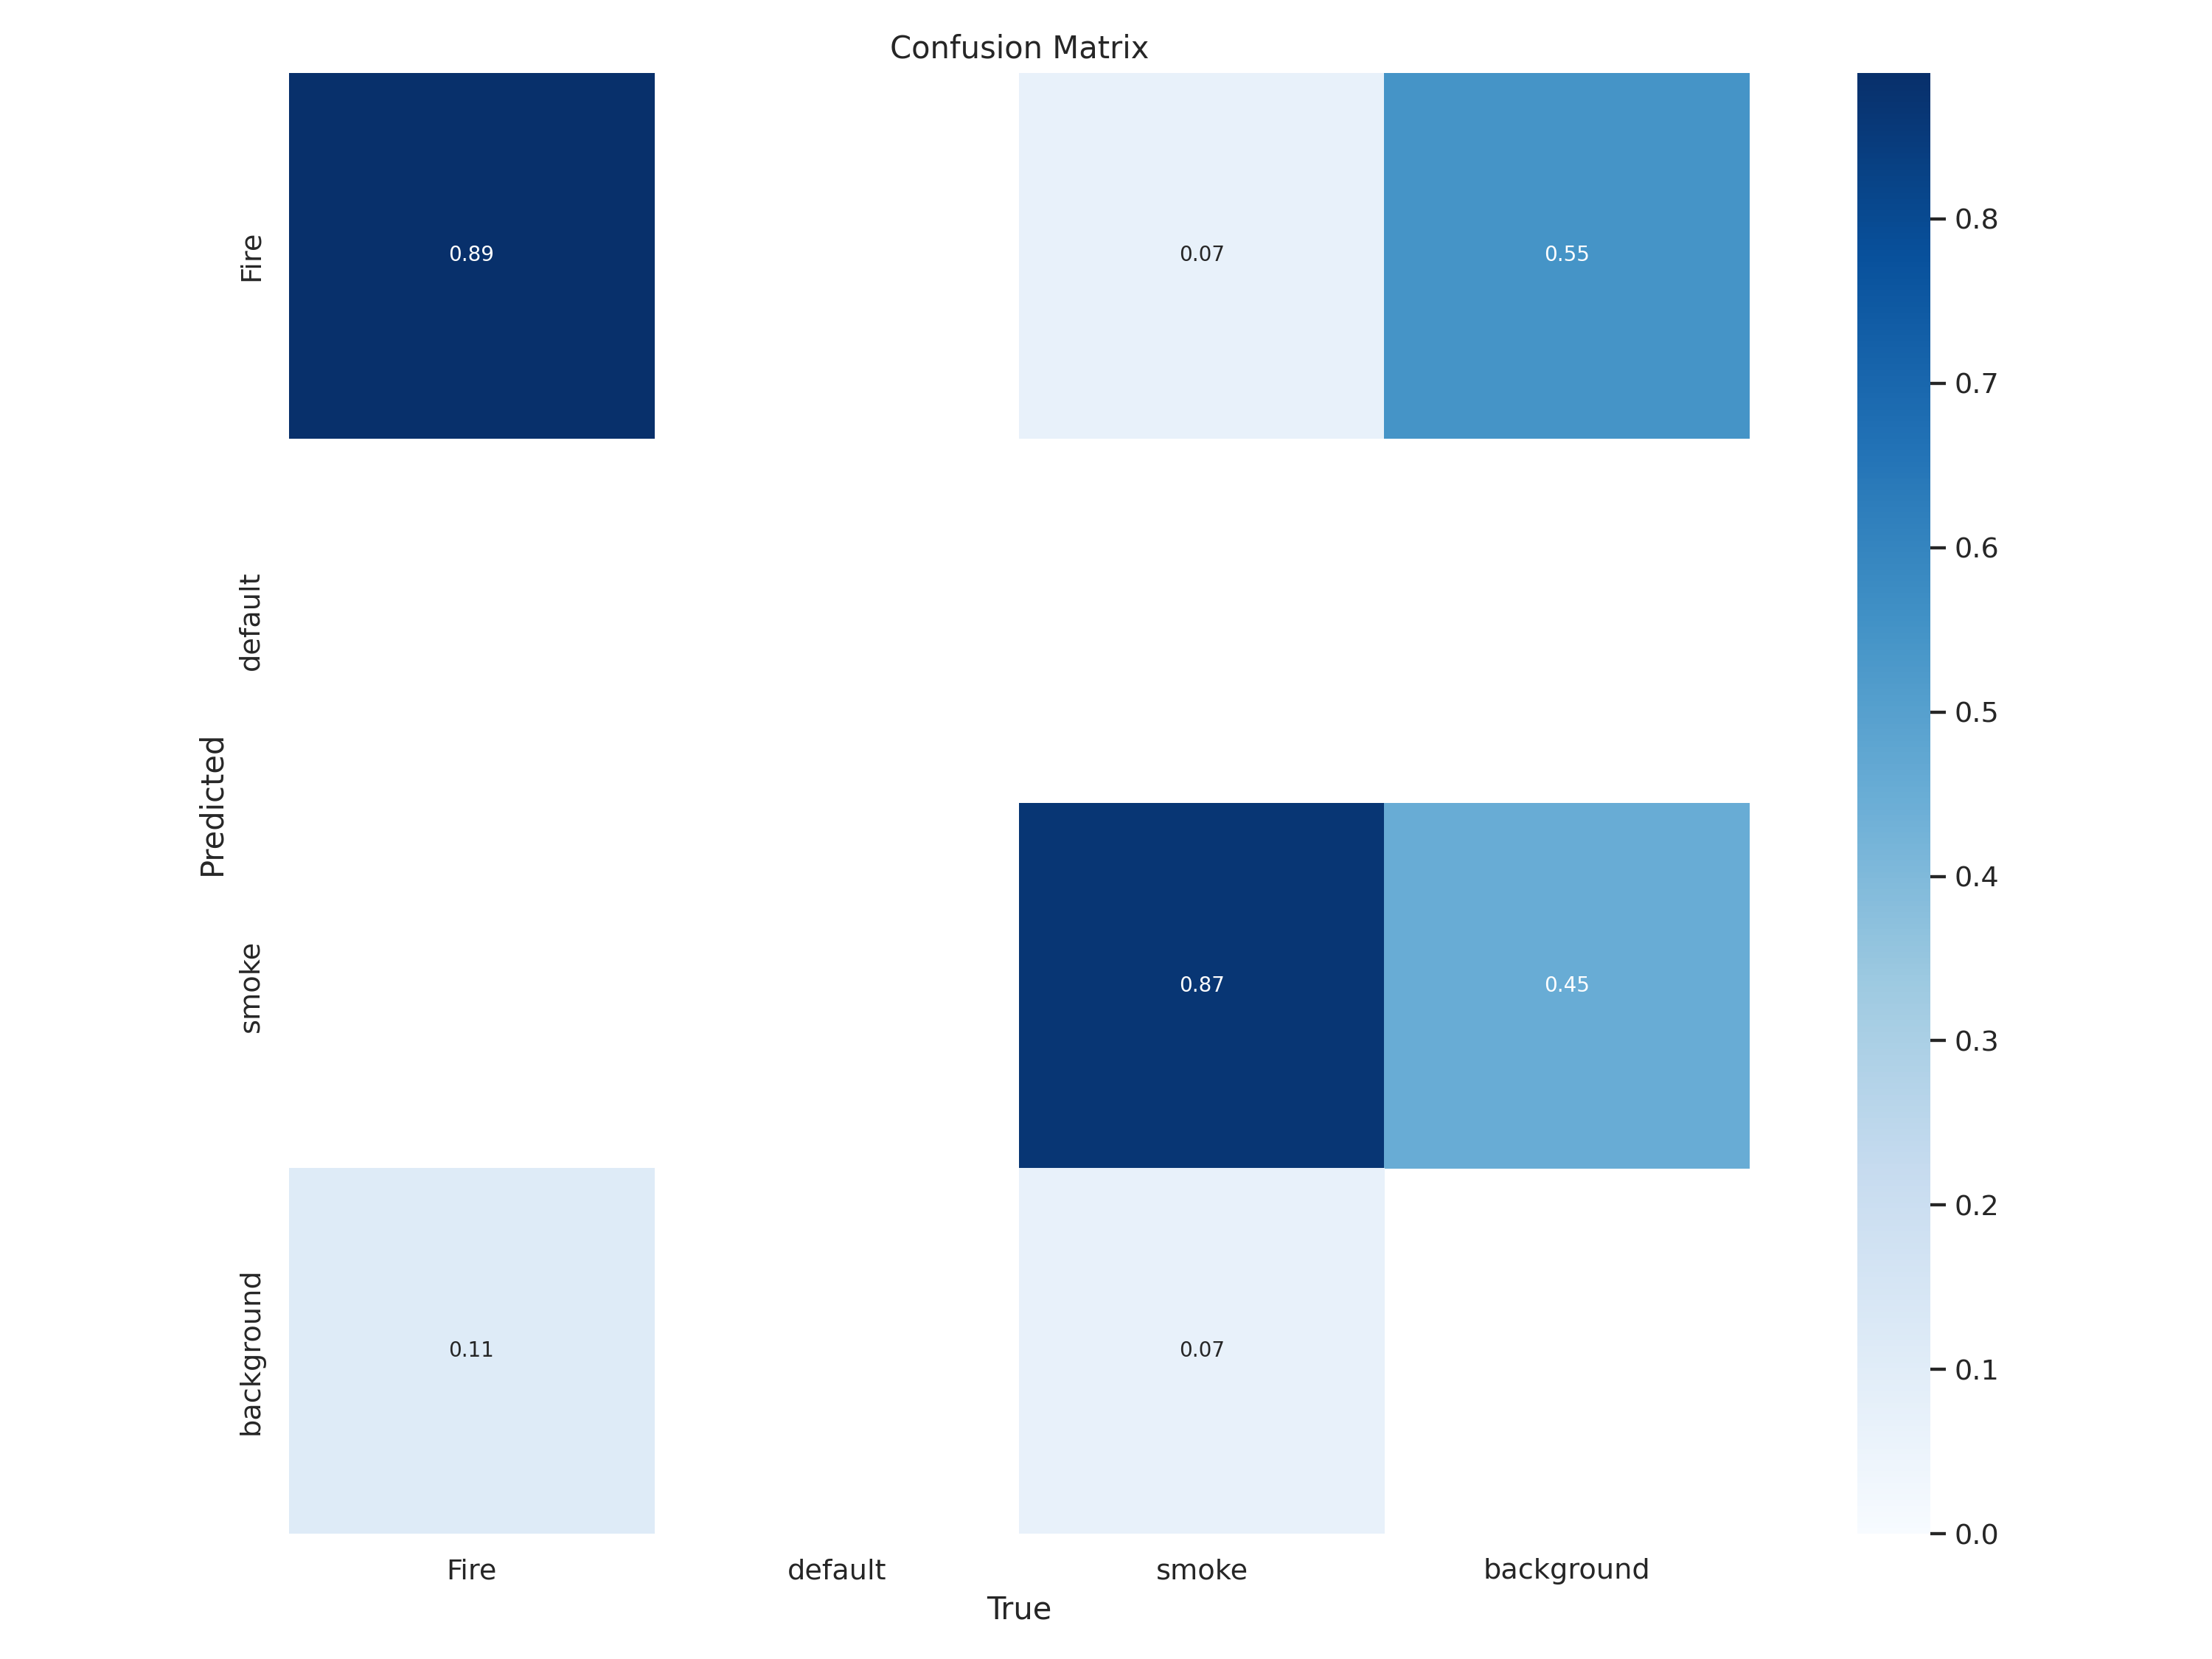

In [53]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content/drive/MyDrive/FireDetection


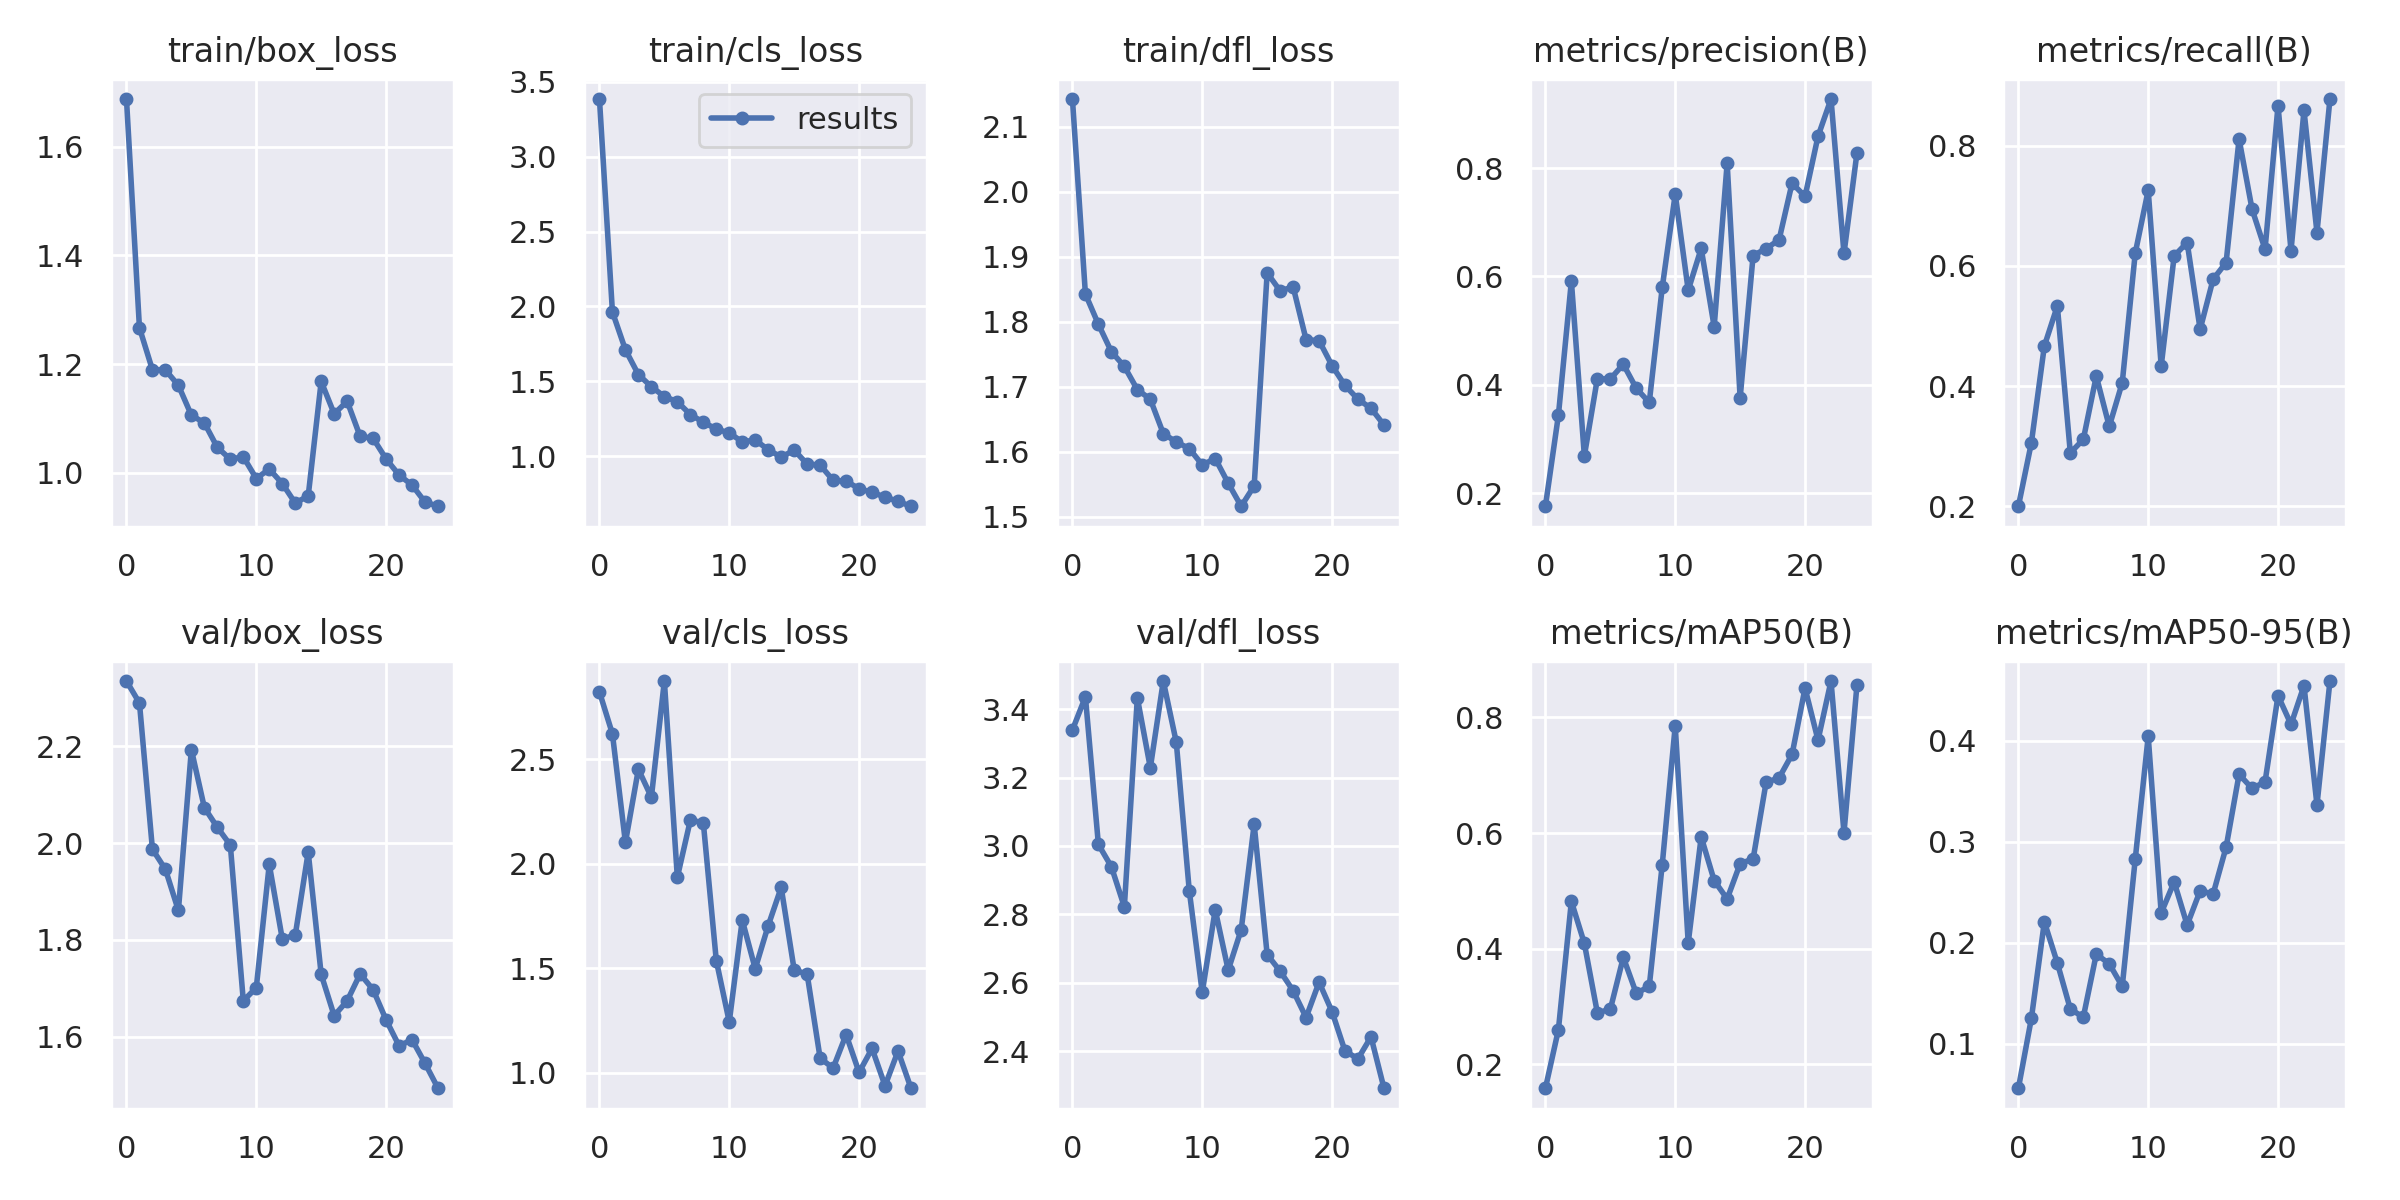

In [55]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content/drive/MyDrive/FireDetection


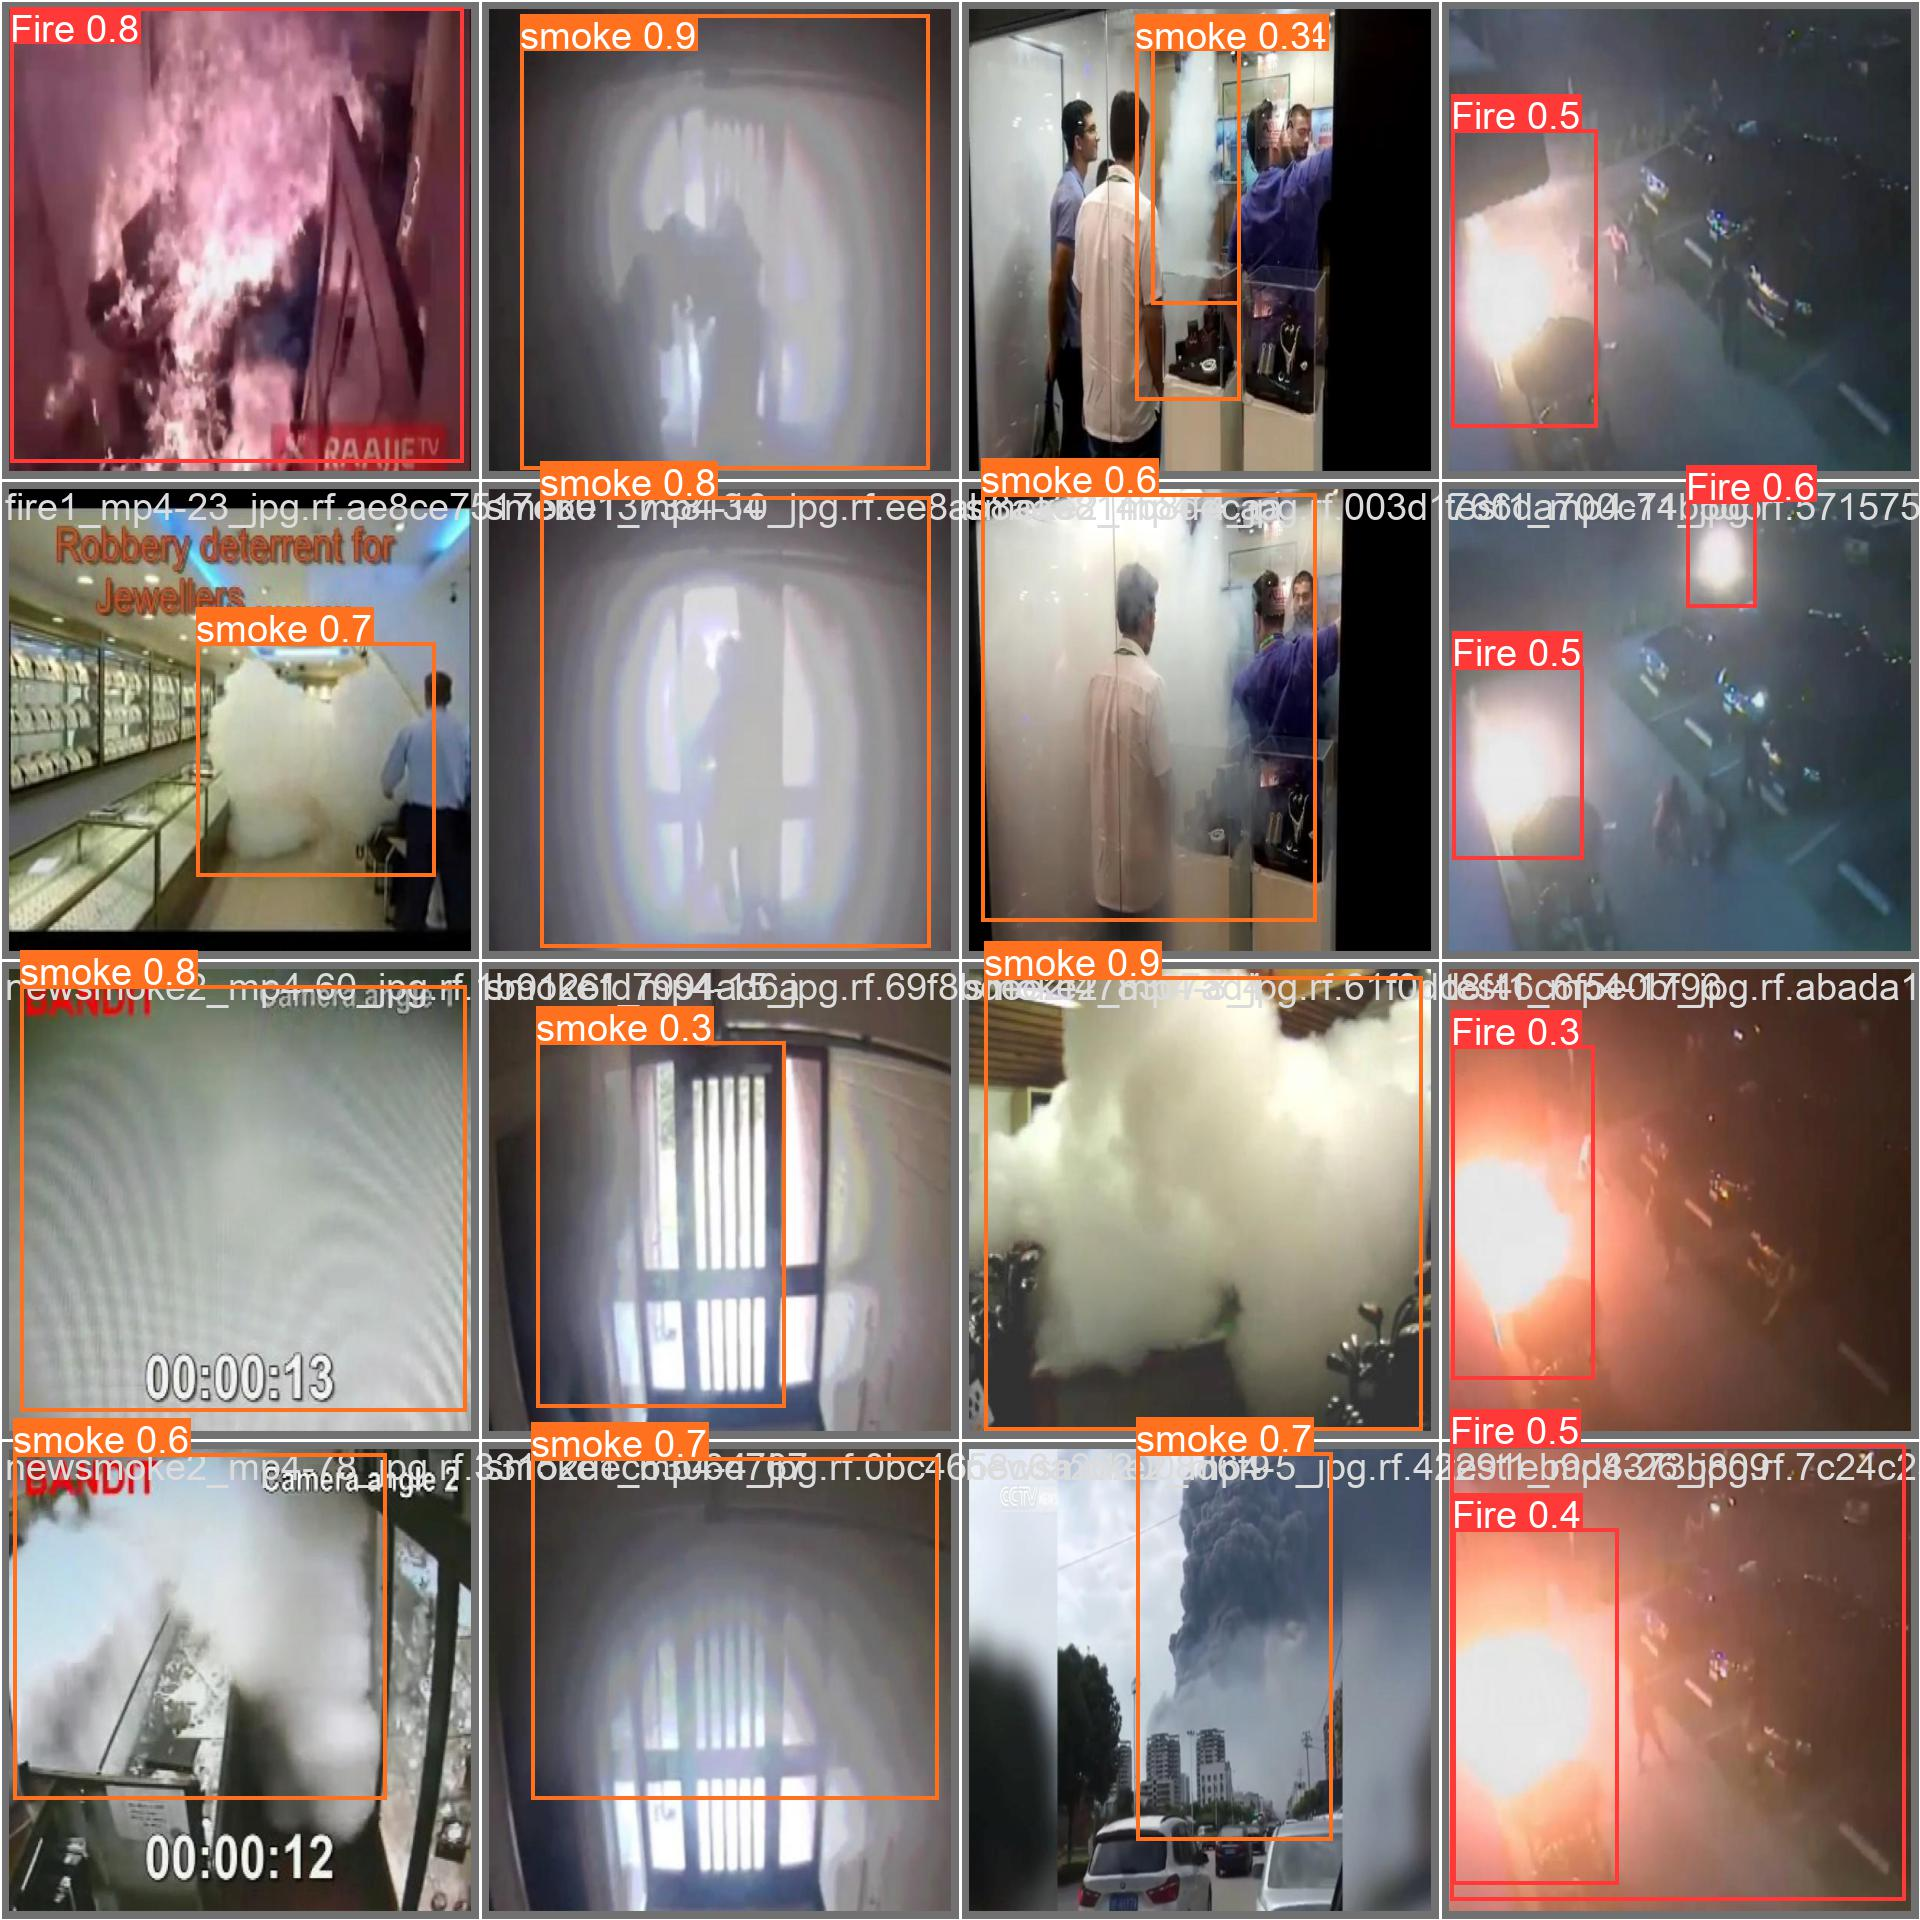

In [56]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [57]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content/drive/MyDrive/FireDetection
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/fire-8/valid/labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100% 47/47 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:02<00:00,  1.13it/s]
                   all         47         48      0.828      0.878      0.857      0.459
                  Fire         47         18      0.761      0.889      0.794      0.376
                 smoke         47         30      0.895      0.867      0.919      0.543
Speed: 4.9ms pre-process, 17.2ms inference, 0.0ms loss, 1.9ms post-process per image


## Inference with Custom Model

In [58]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content/drive/MyDrive/FireDetection
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
image 1/55 /content/drive/MyDrive/FireDetection/datasets/fire-8/test/images/fire1_mp4-26_jpg.rf.5a09c11c9facf23a9413ca63bc2a6085.jpg: 800x800 1 Fire, 26.1ms
image 2/55 /content/drive/MyDrive/FireDetection/datasets/fire-8/test/images/fire2_mp4-29_jpg.rf.42a82dddeb68db98ca428fdf902c9e66.jpg: 800x800 1 Fire, 26.2ms
image 3/55 /content/drive/MyDrive/FireDetection/datasets/fire-8/test/images/fire2_mp4-37_jpg.rf.742a554b0f0772dc0fb772be8648477c.jpg: 800x800 1 Fire, 24.5ms
image 4/55 /content/drive/MyDrive/FireDetection/datasets/fire-8/test/images/fire2_mp4-50_jpg.rf.07b08a19a25759f464ebccd1158f1d23.jpg: 800x800 1 Fire, 24.5ms
image 5/55 /content/drive/MyDrive/FireDetection/datasets/fire-8/test/images/fire2_mp4-51_jpg.rf.09ddf16d6c4c8117c7a4a5f26f796a44.jpg: 800x800 1 Fire, 24.6ms
image 6/55

**NOTE:** Let's take a look at few results.

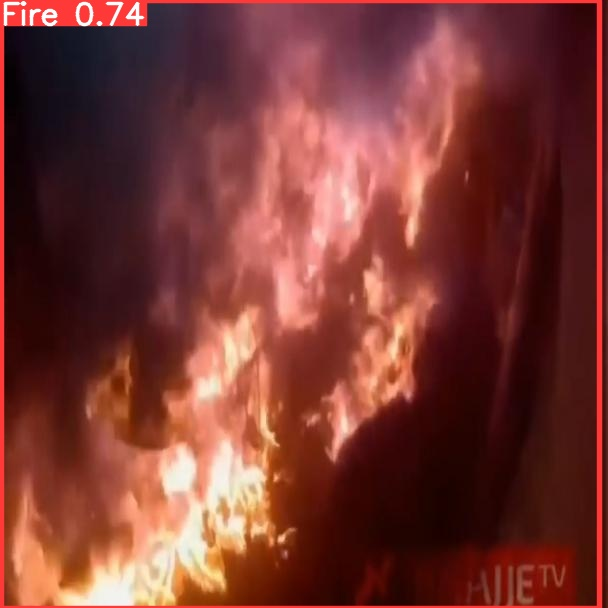

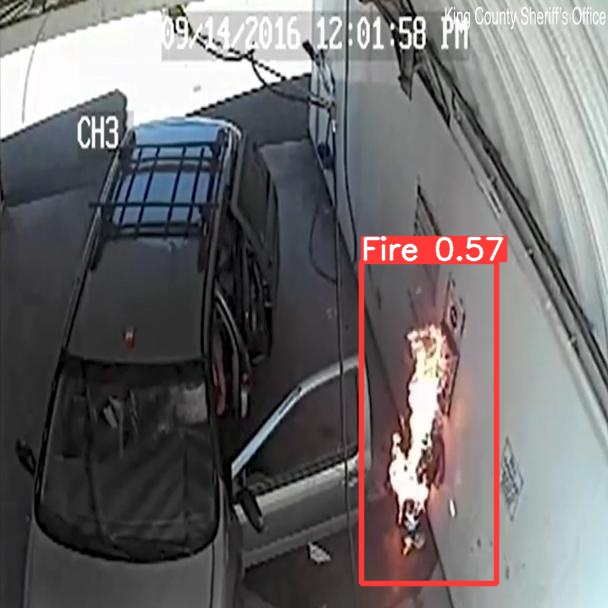

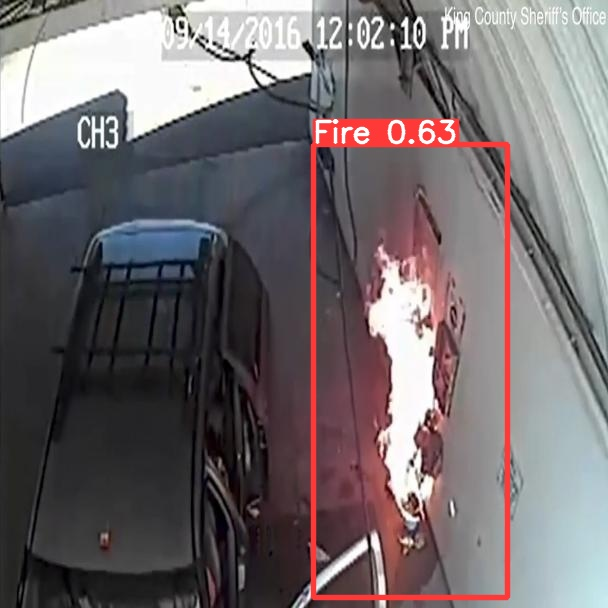

In [59]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [70]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/forest-fire_5.mp4 save=True

/content/drive/MyDrive/FireDetection
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
video 1/1 (1/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 1 Fire, 20.4ms
video 1/1 (2/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 1 Fire, 16.6ms
video 1/1 (3/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 1 Fire, 19.0ms
video 1/1 (4/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 2 Fires, 16.6ms
video 1/1 (5/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 1 Fire, 16.5ms
video 1/1 (6/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 1 Fire, 16.5ms
video 1/1 (7/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 1 Fire, 16.5ms
video 1/1 (8/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 2 Fires, 16.5ms
video 1/1 (9/414) /content/drive/MyDrive/forest-fire_5.mp4: 480x800 2 Fires, 16.5ms
video 1/1 (10/414) /content/drive/MyDrive/for

## Conclusion

Early fire detection  
This project  is inspired by 'Fire Fire everywhere, not a tree alive!'. This quote perfectly fits the Amazon rainforest fires, which became a global concern in 2019. It is crucial to prevent such forest fires if we wish to fight against climate change. And a solution for this can be provided by deep learning algorithms. One can use the RGB model of colors to identify fire and smoke regions in an image.

This tutorial walks you through how we can use yolov8 to fine tune the fire detection model.It can be trained with more different images as per the use case in order to get efficient result. Thanks for learning with me.Stay tune for next topic.